In [295]:
import numpy as np
from scipy.optimize import fsolve

import matplotlib.pyplot as plt
%matplotlib inline  

# Rocket engine thrust as described in 
# https://www.grc.nasa.gov/www/k-12/airplane/rktthsum.html


p_t = 300. * 10**5  # pressure in tank [Pa]
T_t = 300.          # temperature in tank [K]
d_star = .01        # diameter at throat [m]
d_e = .1            # diameter at exit [m]

def computeThrust(p_t, T_t, d_star, d_e, debug=False):
    gam = 1.4           # specific heat ratio for oxygen
    R = 287.058         # specific gas constant for oxygen [J/kg/K]
    p_0 = 862.          # vacuum tube pressure [Pa]


    A_e = np.pi * (d_e/2.)**2.
    A_star = np.pi * (d_star/2.)**2.


    m_dot = (A_star * p_t / np.sqrt(T_t)) * np.sqrt(gam/R) * ((gam+1.)/2.)**(-((gam+1.)/(gam-1.)/2.))
    M_e = fsolve(
        lambda M: (((gam+1.)/2.)**(-((gam+1.)/(gam-1.)/2))) / M * (1. + M**2. * (gam-1.)/2.)**((gam+1.)/(gam-1.)/2.) - A_e/A_star
        , 100.)[0]
    p_e = p_t * (1. + M_e**2. * (gam-1.)/2.)**(-(gam/(gam-1.)))
    T_e = T_t * (1. + M_e**2. * (gam-1.)/2.)**(-1.)
    v_e = M_e * np.sqrt(gam * R * T_e)
    F = m_dot * v_e + (p_e - p_0) * A_e

    if debug:
        print """
        Thrust: {} [kN]
        m_dot:  {} [kg/s]
        v_e:    {} [m/s]
        M_e:    {} 
        p_e:    {} [Pa]
        T_e:    {} [K]
        """.format(F/1000., m_dot, v_e, M_e, p_e, T_e)

        print """
        m_dot * v_e:       {} [kN]
        (p_e - p_0) * A_e: {} [kN]
        """.format(m_dot * v_e/1000., (p_e - p_0) * A_e/1000.)
    
    return F

computeThrust(p_t, T_t, d_star, d_e, True)


        Thrust: 4.1162089094 [kN]
        m_dot:  5.49776232808 [kg/s]
        v_e:    738.966762721 [m/s]
        M_e:    6.93629038982 
        p_e:    7679.59674248 [Pa]
        T_e:    28.242139017 [K]
        

        m_dot * v_e:       4.06266362979 [kN]
        (p_e - p_0) * A_e: 0.0535452796033 [kN]
        


4116.2089093962331

In [245]:
# compute d_star at 3 kN
fsolve(lambda x: computeThrust(p_t, T_t, x, d_e)-3000., 10., )[0]

0.0085211158478690815

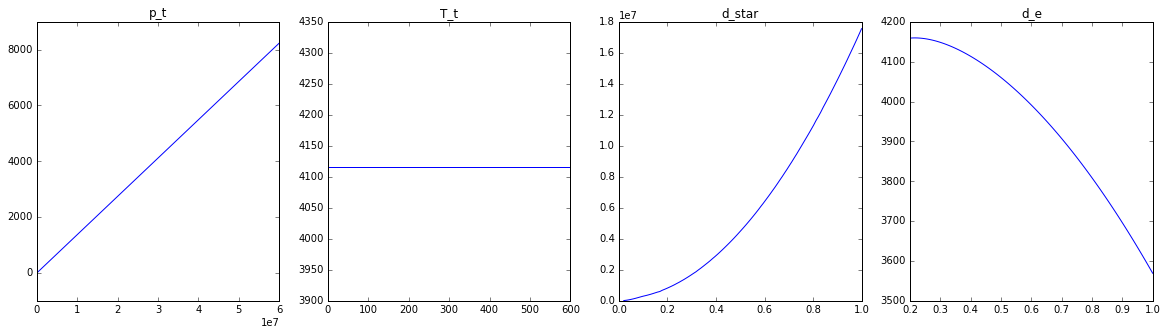

In [297]:
# Thrust vs [ p_t, T_t, d_star, d_e ]

# Actual value in center of the x-axis

plt.rcParams['figure.figsize'] = (20, 5)
thrust = np.vectorize(computeThrust)

f, ax = plt.subplots(1,4)

p = np.linspace(1,2.*p_t,100)
ax[0].set_title('p_t')
ax[0].plot(p, thrust(p, T_t, d_star, d_e))

T = np.linspace(1,2.*T_t,100)
ax[1].set_title('T_t')
ax[1].plot(T, thrust(p_t, T, d_star, d_e))

d = np.linspace(1,2.*d_star,100)
ax[2].set_title('d_star')
ax[2].plot(d, thrust(p_t, T_t, d, d_e))

d = np.linspace(1,2.*d_e,100)
ax[3].set_title('d_e')
ax[3].plot(d, thrust(p_t, T_t, d_star, d))